# Automatic Symbolic Differentiation

### Dependencies

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib

%matplotlib inline
# matplotlib.rcParams['figure.figsize'] = (6.4 * 2, 4.8 * 2)

### Graph operations definitions

In [2]:
class Op(object):
  def ind(self, s, i):
    return '  ' * i + s
  
  def __add__(self, x):
    return Add(self, x)
  
  def __sub__(self, x):
    return Sub(self, x)
  
  def __mul__(self, x):
    return Mul(self, x)
  
  def __truediv__(self, x):
    return Div(self, x)
  
  def __pow__(self, x):
    return Pow(self, x)

class BinaryOp(Op):
  def __init__(self, a, b):
    self.a = a
    self.b = b
    
  def __str__(self, i=0):
    return '\n'.join([
      self.ind(self.op_name + '(', i),
      self.a.__str__(i + 1) + ',',
      self.b.__str__(i + 1),
      self.ind(')', i)
    ])
  
class Const(Op):
  def __init__(self, x):
    self.x = x
    
  def __str__(self, i=0):
    return self.ind('Const(%s)' % self.x, i)
    
  def eval(self, feeds):
    return self.x
  
  def deriv(self, var):
    if var == self:
      return Const(1)
    else:
      return Const(0)

class Placeholder(Op):
  def __init__(self, name):
    self.name = name
    
  def __str__(self, i=0):
    return self.ind('Placeholder(\"%s\")' % self.name, i)
    
  def eval(self, feeds):
    return feeds[self]
  
  def deriv(self, var):
    if var == self:
      return Const(1)
    else:
      return Const(0)
  
class Add(BinaryOp):    
  op_name = 'Add'
    
  def eval(self, feeds):
    return self.a.eval(feeds) + self.b.eval(feeds)
  
  def deriv(self, var):
    return self.a.deriv(var) + self.b.deriv(var)

class Sub(BinaryOp):
  op_name = 'Sub'
    
  def eval(self, feeds):
    return self.a.eval(feeds) - self.b.eval(feeds)
  
  def deriv(self, var):
    return self.a.deriv(var) - self.b.deriv(var)
  
class Mul(BinaryOp):
  op_name = 'Mul'
    
  def eval(self, feeds):
    return self.a.eval(feeds) * self.b.eval(feeds)
  
  def deriv(self, var):
    return (self.a * self.b.deriv(var)) + (self.b * self.a.deriv(var))
  
class Div(BinaryOp):
  op_name = 'Div'
    
  def eval(self, feeds):
    return self.a.eval(feeds) / self.b.eval(feeds)
  
  def deriv(self, var):
    return (self.b * self.a.deriv(var) - self.a * self.b.deriv(var)) / (self.b ** Const(2))
  
class Pow(BinaryOp):
  op_name = 'Pow'
    
  def eval(self, feeds):
    return self.a.eval(feeds) ** self.b.eval(feeds)
  
  def deriv(self, var):
    return ((self.b * self.a) ** (self.b - Const(1))) * self.a.deriv(var)

### Build a graph

In [3]:
a = Placeholder('a')
b = Const(2)

c = (a + b) * (b - a)
c = c / Const(2)
c = c ** Const(2)

ad = c.deriv(a)

print('c graph:\n%s' % c)
# print('ad graph: %s' % ad)

c graph:
Pow(
  Div(
    Mul(
      Add(
        Placeholder("a"),
        Const(2)
      ),
      Sub(
        Const(2),
        Placeholder("a")
      )
    ),
    Const(2)
  ),
  Const(2)
)


### Evaluate graph and derivatives

In [4]:
x = np.array([3, 4, 5])
print('c = %s' % c.eval({a: x}))

delta = 0.00001
ad_num = (c.eval({a: x + delta}) - c.eval({a: x})) / delta

print('ad = %s' % ad.eval({a: x}))
print('numerical ad = %s' % ad_num)

c = [   6.25   36.    110.25]
ad = [  15.   48.  105.]
numerical ad = [  15.000115     48.00022     105.00035499]


# Gradient Descent

### Dataset 

In [5]:
x = 5
y = x * 3.75 + 1.25
w = -1
b = 1.25

### Build a graph

In [6]:
def make_feeds(overrides={}):
  feeds = {
    xph: x, 
    yph: y, 
    wph: w, 
    bph: b
  }
  return {**feeds, **overrides}

xph = Placeholder('x')
yph = Placeholder('y')
wph = Placeholder('w')
bph = Placeholder('b')

y_hat = xph * wph + bph
loss = (y_hat - yph) ** Const(2)
wd = loss.deriv(wph)
bd = loss.deriv(bph)

print('loss graph: \n%s' % loss)

loss graph: 
Pow(
  Sub(
    Add(
      Mul(
        Placeholder("x"),
        Placeholder("w")
      ),
      Placeholder("b")
    ),
    Placeholder("y")
  ),
  Const(2)
)


### Train

loss = 564.0625
step: 0, loss: 402.65940564062504
step: 10, loss: 13.83706720869469
step: 20, loss: 0.4754997058452332
step: 30, loss: 0.01634016564701127
step: 40, loss: 0.0005615166741211749
step: 50, loss: 1.9296069705014235e-05
w = 3.59, b = 2.03


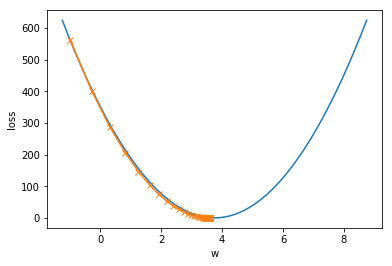

In [7]:
steps = 51
log_interval = 10
learning_rate = 0.003
descents = []

l = loss.eval(make_feeds())
print('loss = %s' % l)
ws = np.linspace(3.75 - 5, 3.75 + 5)
plt.plot(ws, loss.eval(make_feeds({wph: ws})))

descents.append([w, l])
for i in range(steps):
  w -= learning_rate * wd.eval(make_feeds())
  b -= learning_rate * bd.eval(make_feeds())
  l = loss.eval(make_feeds())
  descents.append([w, l])
  
  if i % log_interval == 0:
    print('step: %d, loss: %s' %(i, loss.eval(make_feeds())))

print('w = %.2f, b = %.2f' % (w, b))

descents = np.array(descents)
plt.plot(descents[:, 0], descents[:, 1], '-x')
plt.xlabel('w')
plt.ylabel('loss')

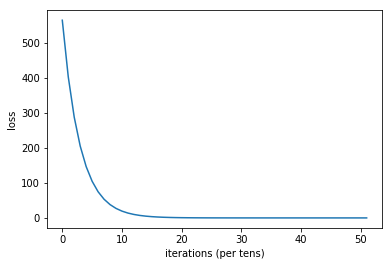

In [8]:
plt.plot(descents[:, 1])
plt.xlabel('iterations (per tens)')
plt.ylabel('loss')